<a href="https://colab.research.google.com/github/sinyoung0110/DeepLearning/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import sys

assert sys.version_info >= (3, 7)

In [4]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121920 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [7]:
if not tf.config.list_physical_devices('GPU'):
    print("GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.")
    if "google.colab" in sys.modules:
        print("런타임 > 런타임 유형 변경으로 이동하여 GPU를 선택하세요.")

In [8]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [9]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # 더 짧은 이름
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # total은 단순히 bus + rail 이므로 삭제합니다.
df = df.drop_duplicates()  # 중복된 월 제거 (2011-10와 2014-07)

In [10]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


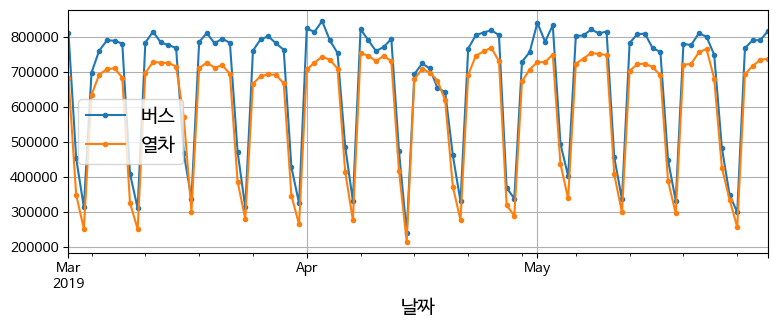

In [11]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.legend(["버스", "열차"]);
plt.xlabel("날짜")
save_fig("daily_ridership_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

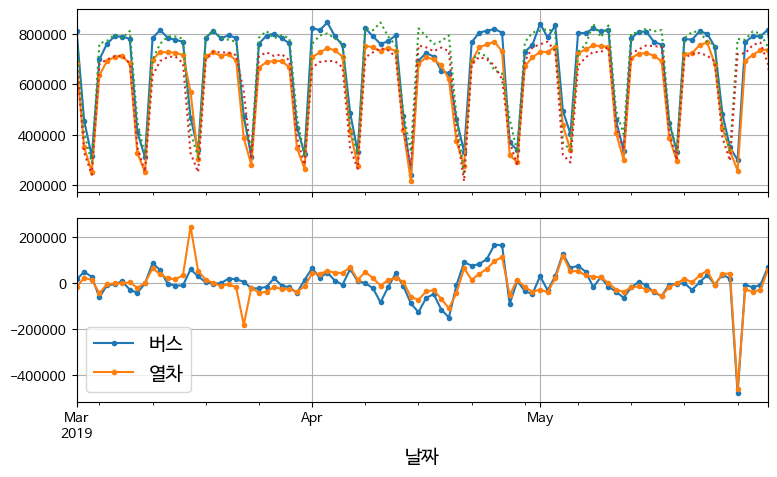

In [12]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # 원본 시계열
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # 지연
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7일 차분 시계열
axs[1].legend(["버스", "열차"])
axs[1].set_xlabel("날짜")
axs[0].set_ylim([170_000, 900_000])  # 추가 코드 - 그래프를 아름답게 꾸미기
save_fig("differencing_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

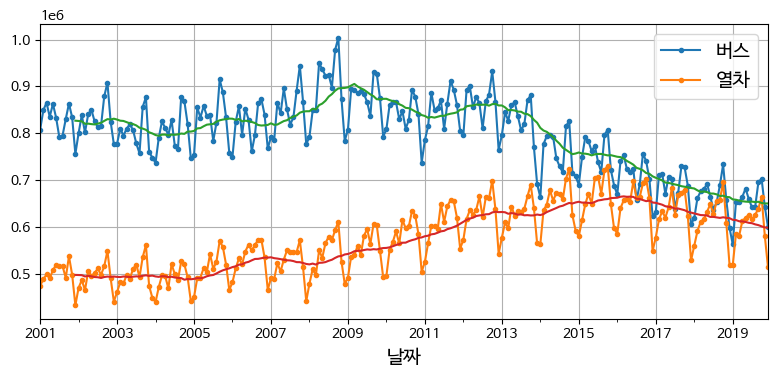

In [16]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean(numeric_only=True)  # 월별 평균을 계산합니다.
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
ax.legend(["버스", "열차"]);
ax.set_xlabel('날짜')
save_fig("long_term_ridership_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

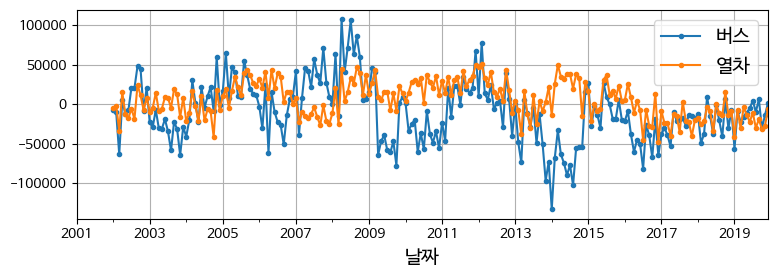

In [17]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.legend(["버스", "열차"])
plt.xlabel("날짜")
save_fig("yearly_diff_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

In [19]:
from statsmodels.tsa.arima.model import ARIMA

origin, today="2019-01-01","2019-05-31"
rail_series=df.loc[origin:today]["rail"].asfreq("D")
model=ARIMA(rail_series,order=(1,0,0),
            seasonal_order=(0,1,1,7))
model=model.fit()
y_pred=model.forecast()

In [20]:
y_pred[0]  # ARIMA 예측

427758.62641035335

In [21]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # "오늘"까지의 데이터로 훈련
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # 매일 모델을 재훈련한다는 점에 유의하세요!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # 32,040.7 반환

In [23]:
mae

32040.720089453378

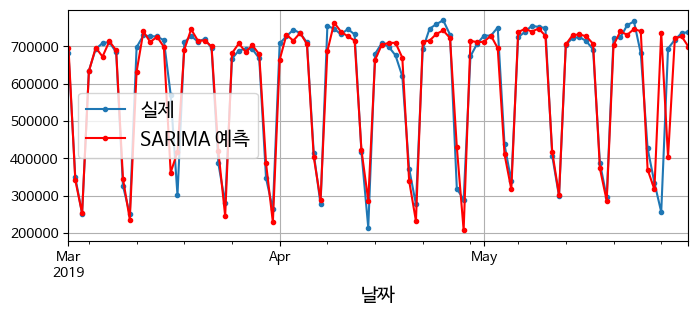

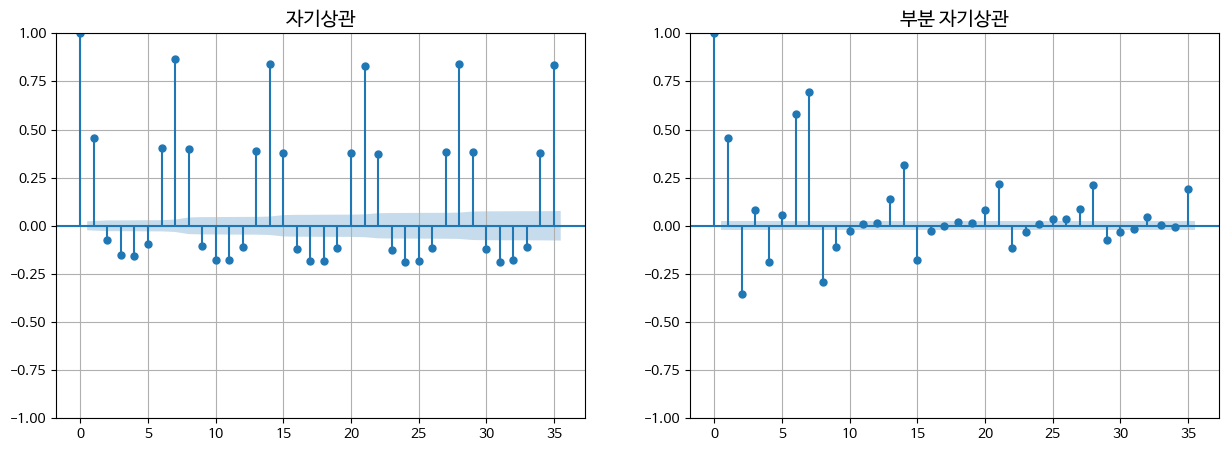

In [25]:
# 추가 코드 - SARIMA 예측을 표시합니다.
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="실제", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA 예측")
ax.set_xlabel("날짜")
plt.legend()
# 추가 코드 - 자기 상관관계 함수(ACF) 및
# 부분 자기 상관관계 함수(PACF)를 그리는 방법을 보여줍니다.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35, title="자기상관")
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm",
          title="부분 자기상관")
axs[1].grid()
plt.show()
plt.show()

In [26]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # 타깃은 미래 3 스텝 앞의 값입니다.
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [27]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [28]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")


[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [29]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [30]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [31]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [32]:
seq_length = 56
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [33]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 4s 16ms/step - loss: 0.0380 - mae: 0.2079 - val_loss: 0.0075 - val_mae: 0.0980
Epoch 2/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0079 - mae: 0.0927 - val_loss: 0.0044 - val_mae: 0.0744
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0067 - mae: 0.0829 - val_loss: 0.0043 - val_mae: 0.0734
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0063 - mae: 0.0789 - val_loss: 0.0038 - val_mae: 0.0676
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0058 - mae: 0.0752 - val_loss: 0.0036 - val_mae: 0.0647
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0055 - mae: 0.0717 - val_loss: 0.0042 - val_mae: 0.0718
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0055 - mae: 0.0739 - val_loss: 0.0034 - val_mae: 0.0614
Epoch 8/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0057 

In [34]:
# 추가 코드 - 모델을 평가합니다.
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 7ms/step - loss: 0.0020 - mae: 0.0360


35983.48796367645

In [35]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [36]:
# 추가 코드 - 여러 번 재사용할 유틸리티 함수를 정의합니다.

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [37]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # 기본적으로 활성화 함수 없음
])

In [38]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [39]:
# 추가 코드 - 이전과 같이 모델을 컴파일, 훈련 및 평가합니다.
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 14s 271ms/step - loss: 0.0605 - mae: 0.2670 - val_loss: 0.0233 - val_mae: 0.1427
Epoch 2/500
33/33 [==============================] - 7s 219ms/step - loss: 0.0144 - mae: 0.1404 - val_loss: 0.0100 - val_mae: 0.1084
Epoch 3/500
33/33 [==============================] - 4s 122ms/step - loss: 0.0090 - mae: 0.1100 - val_loss: 0.0048 - val_mae: 0.0772
Epoch 4/500
33/33 [==============================] - 5s 159ms/step - loss: 0.0067 - mae: 0.0864 - val_loss: 0.0037 - val_mae: 0.0672
Epoch 5/500
33/33 [==============================] - 4s 123ms/step - loss: 0.0057 - mae: 0.0779 - val_loss: 0.0043 - val_mae: 0.0757
Epoch 6/500
33/33 [==============================] - 4s 122ms/step - loss: 0.0053 - mae: 0.0737 - val_loss: 0.0025 - val_mae: 0.0517
Epoch 7/500
33/33 [==============================] - 5s 161ms/step - loss: 0.0048 - mae: 0.0677 - val_loss: 0.0026 - val_mae: 0.0519
Epoch 8/500
33/33 [==============================] - 4s 125ms/step -

29043.43791306019

In [40]:
df_mulvar = df[["bus", "rail"]] / 1e6  # 버스 및 열차 시계열을 모두 입력으로 사용
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # 내일의 유형을 알고 있습니다.
df_mulvar = pd.get_dummies(df_mulvar)  # 요일 유형을 원-핫 인코딩합니다.

mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [41]:
import numpy as np

tf.random.set_seed(42)  # 추가 코드 - 재현성 보장

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(np.float32),  # 5개의 열을 모두 입력으로 사용
    targets=mulvar_train["rail"][seq_length:],  # 열차 시계열만 예측
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(np.float32),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [42]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [43]:
# 추가 코드 - 이전과 같이 모델을 컴파일, 훈련 및 평가합니다.
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 5s 75ms/step - loss: 0.0085 - mae: 0.0891 - val_loss: 0.0027 - val_mae: 0.0635
Epoch 2/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0025 - mae: 0.0500 - val_loss: 0.0027 - val_mae: 0.0635
Epoch 3/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0022 - mae: 0.0468 - val_loss: 9.5550e-04 - val_mae: 0.0321
Epoch 4/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0021 - mae: 0.0465 - val_loss: 0.0017 - val_mae: 0.0500
Epoch 5/500
33/33 [==============================] - 2s 49ms/step - loss: 0.0018 - mae: 0.0408 - val_loss: 0.0010 - val_mae: 0.0347
Epoch 6/500
33/33 [==============================] - 2s 51ms/step - loss: 0.0019 - mae: 0.0436 - val_loss: 0.0013 - val_mae: 0.0421
Epoch 7/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0016 - mae: 0.0391 - val_loss: 9.2504e-04 - val_mae: 0.0314
Epoch 8/500
33/33 [==============================] - 1s 37ms/step - 

22316.932678222656

In [44]:
# 추가 코드 - 버스와 열차를 모두 예측하는 멀티태스크 RNN 구축 및 훈련

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(np.float32),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 타깃 2개
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(np.float32),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 5s 96ms/step - loss: 0.0442 - mae: 0.2031 - val_loss: 0.0038 - val_mae: 0.0665
Epoch 2/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0039 - mae: 0.0620 - val_loss: 0.0021 - val_mae: 0.0485
Epoch 3/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0028 - mae: 0.0503 - val_loss: 0.0011 - val_mae: 0.0326
Epoch 4/500
33/33 [==============================] - 3s 93ms/step - loss: 0.0024 - mae: 0.0480 - val_loss: 0.0018 - val_mae: 0.0468
Epoch 5/500
33/33 [==============================] - 2s 61ms/step - loss: 0.0023 - mae: 0.0468 - val_loss: 9.4513e-04 - val_mae: 0.0299
Epoch 6/500
33/33 [==============================] - 2s 60ms/step - loss: 0.0022 - mae: 0.0447 - val_loss: 0.0010 - val_mae: 0.0328
Epoch 7/500
33/33 [==============================] - 2s 67ms/step - loss: 0.0020 - mae: 0.0445 - val_loss: 9.0290e-04 - val_mae: 0.0295
Epoch 8/500
33/33 [==============================] - 3s 81ms/step - 

25112.9399985075

In [45]:
# 추가 코드 - 버스에 대한 순진한 예측을 평가합니다.
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [46]:
# 추가 코드 - 버스와 열차 모두에 대한 멀티태스크 RNN의 예측을 평가합니다.
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 0s 9ms/step
bus 26320
rail 23905


In [47]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 23ms/step


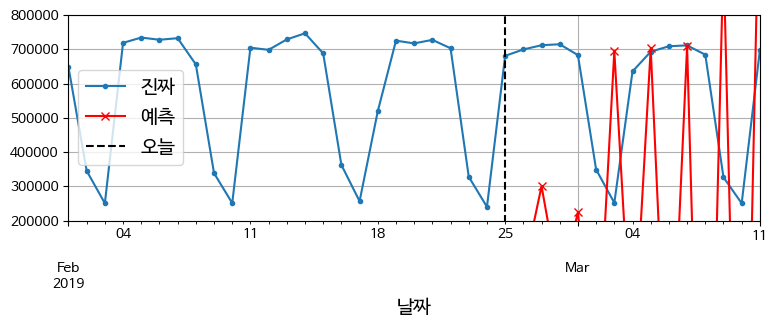

In [48]:
# 추가 코드 - 그림 15-11 생성 및 저장

# 예측은 2019년 57일째인 2019-02-26에 시작하여 2019-03-11에 종료됩니다. 총 14일입니다.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="진짜", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="예측", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="오늘")
ax.set_ylim([200_000, 800_000])
ax.set_xlabel("날짜")
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()